# Project 2
***

The goal of this project is to compare machine learning models to find the best one to categorize tweets from US Senators into what political party that Senator is in (Democrat or Republican) based on its qualities. 

## Import block

In [4]:
# Import Block 
%matplotlib inline

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import math
import random 

from proj2 import * 

from sklearn import linear_model 
from sklearn.metrics import accuracy_score
# Used for Trees
from sklearn.tree import DecisionTreeClassifier  
from sklearn.tree import export_graphviz 
from IPython.display import Image 
from pydot import graph_from_dot_data
from six import StringIO
from random import seed

# Used for SVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score



## Data Pre-processing
***
I use the `senators.csv` file to get the tweet data I will use for my analysis. This data contains the exact tweet text of many US Senators, along with information about the tweets like how many retweets and likes it had, who wrote it, what state the writer was from, etc. 

To start, I remove any tweets written by senators that were not either Democratic or Republican, because there were so few of them relative to Democrats and Republicans (6255 independent parties, 282360 Democrats + Republicans) that I did not think they were useful to include. I also drop some columns I don't see myself using, like the `url` of the tweer and the `bioguide_id`.  

Then, I randomly sampled 90 % of my tweet data to use for training and testing my models (`main_train_df`). I am making two different models that I might use for my categorization task, and I want to reserve the final 10% of my tweet data (`final_test_df`) for testing and comparing those two models, to hopefully give a more objective measure of their qualities. This 10% is saved in a separate dataframe so I don't lose or use it by accident before the end. 

The `main_train_df`, which I am using to train and test the two separate models, also needs to be split into a test sample and a train sample. I randomly sample the `main_train_df`, and then copy the subsampled version (`tree_train_df`) so that each of my models has an identical random train and test set. 

I need two different copies of this secondary training set so each of my models has their own clean dataset to work with. My models have very different data needs, so each dataframe undergoes significant changes and cannot be shared. Similarly, both get their own copy of the other 10% of the `main_train_df`, so I can modify the test sets to suite their needs as well.

In [5]:
# Data import block 
my_df = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/twitter-ratio/senators.csv", encoding="ISO-8859-1")


In [6]:
# tests
print(my_df.shape)
my_df.head()

(288615, 10)


,created_at,text,url,replies,retweets,favorites,user,bioguide_id,party,state
0,10/19/17 21:47,We released bipartisan healthcare bill today &...,https://twitter.com/amyklobuchar/status/921130...,21,129,533,amyklobuchar,K000367,D,MN
1,10/19/17 18:48,I spoke with @Morning_Joe team abt #HonestAds ...,https://twitter.com/amyklobuchar/status/921085...,8,46,150,amyklobuchar,K000367,D,MN
2,10/19/17 18:14,Lots of interest in my bill with Senators Warn...,https://twitter.com/amyklobuchar/status/921077...,36,227,932,amyklobuchar,K000367,D,MN
3,10/19/17 18:04,"Today's the day @MarkWarner, @SenJohnMcCain &a...",https://twitter.com/amyklobuchar/status/921074...,17,167,550,amyklobuchar,K000367,D,MN
4,10/19/17 16:33,".@MarkWarner, @SenJohnMcCain &amp; I put toget...",https://twitter.com/amyklobuchar/status/921051...,31,279,893,amyklobuchar,K000367,D,MN


In [7]:
# drop all tweets from a senator that isn't either Democratic or Republican 
my_df.drop((my_df[(my_df['party']!='R') & (my_df['party']!='D')].index), inplace=True)

# make sure they were dropped
print(my_df.shape)


(282360, 10)


In [8]:
# Drop columns I never use
my_df = my_df.drop(columns = ['url','bioguide_id']) 

# Check that it worked
my_df.head ()

,created_at,text,replies,retweets,favorites,user,party,state
0,10/19/17 21:47,We released bipartisan healthcare bill today &...,21,129,533,amyklobuchar,D,MN
1,10/19/17 18:48,I spoke with @Morning_Joe team abt #HonestAds ...,8,46,150,amyklobuchar,D,MN
2,10/19/17 18:14,Lots of interest in my bill with Senators Warn...,36,227,932,amyklobuchar,D,MN
3,10/19/17 18:04,"Today's the day @MarkWarner, @SenJohnMcCain &a...",17,167,550,amyklobuchar,D,MN
4,10/19/17 16:33,".@MarkWarner, @SenJohnMcCain &amp; I put toget...",31,279,893,amyklobuchar,D,MN


In [9]:
# Randomly sample 90% of my data to use for training/testing my separate models
main_train_df = my_df.sample(frac=0.9) 

# Save the 10% of my data that was not sampled (that i am going to train with later) separately
final_test_df = my_df[~my_df.apply(tuple,1).isin(main_train_df.apply(tuple,1))]

In [10]:
# make 2 copies of my randomly sampled main_train_df, so each of my models has their own
tree_train_df = main_train_df.sample(frac=0.9) 
svm_train_df = tree_train_df.copy()

# separate out the test sets fof both models
tree_test_df = main_train_df[~main_train_df.apply(tuple,1).isin(tree_train_df.apply(tuple,1))]
svm_test_df = tree_test_df.copy()

# check the shape
tree_test_df.shape

(25411, 8)

## Model 1: Decision Tree
***
### Pre-processing my Tree Training Data
***
I want my decision tree to be in binary, meaning each column only has 2 possible values. Unfortunately, my Senator data is not set up that way. To start, I need to convert all of my columns into binary. To do this, I use a function I wrote called `make_bool`, which takes in some kind of condition and splits the column based on it into 2 options.
- for the `made_At` column, I split based on if the tweet was sent before noon
- for the `retweet` column, I split based on if the number of retweets is greater than the median
- for the `replies` column, I split based on if the number of replies is greater than the median
- for the `favorites` column, I split based on if the number of favorites is greater than the median
- for the `user` column, I split based on the gender of the Senator
- for the `state` column, I split based on whether the state historically votes blue or red
- for the `text` column, I split based on whether the tweet mention trump

Finally, I need to first split my train dataframe into `inputs_train` (everything but the `party` column), which are the variables I use to try and guess the `target_train` (only the `party` column), my target that I am trying to classify. 

In [11]:
# this is the function in my code used to turn columns into binary based on some condition
# I have it included here as a reference 

def make_bool_col(data_pd, indx, column_name):

    #indx = data_pd[column_name] > val
    data_pd.loc[indx, column_name] = True
    data_pd.loc[~indx, column_name] = False
    
    # count occurances of true and false
    print(data_pd[column_name].value_counts())
    
    return data_pd

In [12]:
# make created_at column bool

make_bool_col(tree_train_df, (tree_train_df['created_at'].str[-5:-3].astype(int) > 12), 'created_at')
tree_train_df.head()

True     205162
False     23550
Name: created_at, dtype: int64


,created_at,text,replies,retweets,favorites,user,party,state
224228,True,"Sometimes bill titles have good acronyms, some...",3,22,16,SenMikeLee,R,UT
54651,True,Capping off state work period with town meetin...,1,1,2,MikeCrapo,R,ID
199809,True,Just asked @CDCgov @NIAIDNews officials about ...,0,2,4,SenJackReed,D,RI
13913,True,Great to meet John Reynolds at the UNI fb game...,0,0,0,ChuckGrassley,R,IA
114257,True,"Good meeting w/ Georgian @AshleyBell45, associ...",2,6,24,SenatorIsakson,R,GA


In [13]:
# make text column bool

make_bool_col(tree_train_df, (tree_train_df['text'].str.contains('trump', case=True)), 'text') 
tree_train_df.head()

False    228537
True        175
Name: text, dtype: int64


,created_at,text,replies,retweets,favorites,user,party,state
224228,True,False,3,22,16,SenMikeLee,R,UT
54651,True,False,1,1,2,MikeCrapo,R,ID
199809,True,False,0,2,4,SenJackReed,D,RI
13913,True,False,0,0,0,ChuckGrassley,R,IA
114257,True,False,2,6,24,SenatorIsakson,R,GA


In [14]:
# make replies column bool

make_bool_col(tree_train_df, (tree_train_df['replies'] > tree_train_df['replies'].median()), 'replies')
tree_train_df.head()

False    123526
True     105186
Name: replies, dtype: int64


,created_at,text,replies,retweets,favorites,user,party,state
224228,True,False,False,22,16,SenMikeLee,R,UT
54651,True,False,False,1,2,MikeCrapo,R,ID
199809,True,False,False,2,4,SenJackReed,D,RI
13913,True,False,False,0,0,ChuckGrassley,R,IA
114257,True,False,False,6,24,SenatorIsakson,R,GA


In [15]:
# make retweet column bool

make_bool_col(tree_train_df, (tree_train_df['retweets'] > tree_train_df['retweets'].median()), 'retweets')
tree_train_df.head()

False    120426
True     108286
Name: retweets, dtype: int64


,created_at,text,replies,retweets,favorites,user,party,state
224228,True,False,False,True,16,SenMikeLee,R,UT
54651,True,False,False,False,2,MikeCrapo,R,ID
199809,True,False,False,False,4,SenJackReed,D,RI
13913,True,False,False,False,0,ChuckGrassley,R,IA
114257,True,False,False,False,24,SenatorIsakson,R,GA


In [16]:
# make favorite column bool

make_bool_col(tree_train_df, (tree_train_df['favorites'] > tree_train_df['favorites'].median()), 'favorites')
tree_train_df.head()

False    114792
True     113920
Name: favorites, dtype: int64


,created_at,text,replies,retweets,favorites,user,party,state
224228,True,False,False,True,True,SenMikeLee,R,UT
54651,True,False,False,False,False,MikeCrapo,R,ID
199809,True,False,False,False,False,SenJackReed,D,RI
13913,True,False,False,False,False,ChuckGrassley,R,IA
114257,True,False,False,False,True,SenatorIsakson,R,GA


In [17]:
# make user column bool

# list of female senator names
indx = tree_train_df['user'].isin(['amyklobuchar', 'LindseyGrahamSC', 'lisamurkowski', 'maziehirono', 'McCaskillOffice', 'PattyMurray',
        'SenatorBaldwin', 'SenatorCantwell', 'SenatorCollins', 'SenatorFischer', 'SenatorHassan', 
        'SenatorHeitkamp', 'SenatorShaheen', 'SenCapito', 'SenCortezMasto', 'SenDuckworth', 'SenFeinstein',
        'SenGillibrand', 'SenJoniErnst', 'SenKamalaHarris', 'SenStabenow', 'SenWarren' ])

make_bool_col(tree_train_df, indx, 'user')
tree_train_df.head()


False    176810
True      51902
Name: user, dtype: int64


,created_at,text,replies,retweets,favorites,user,party,state
224228,True,False,False,True,True,False,R,UT
54651,True,False,False,False,False,False,R,ID
199809,True,False,False,False,False,False,D,RI
13913,True,False,False,False,False,False,R,IA
114257,True,False,False,False,True,False,R,GA


In [18]:
# make party column bool

make_bool_col(tree_train_df, tree_train_df['party'] == 'D', 'party') 

False    118703
True     110009
Name: party, dtype: int64


,created_at,text,replies,retweets,favorites,user,party,state
224228,True,False,False,True,True,False,False,UT
54651,True,False,False,False,False,False,False,ID
199809,True,False,False,False,False,False,True,RI
13913,True,False,False,False,False,False,False,IA
114257,True,False,False,False,True,False,False,GA
...,...,...,...,...,...,...,...,...
218803,True,False,True,False,False,True,False,IA
259935,True,False,True,True,True,False,False,TX
207833,True,False,True,False,False,False,False,WY
10022,True,False,True,True,True,False,True,MD


In [19]:
# make state column bool

# list of historically red states
indx = tree_train_df['state'].isin(['ID','WA', 'WY','UT','ND','SD',
                            'NE', 'IA','KS','OK','TX','AR',
                            'MO', 'LA','MS','AL','FL','TN', 
                            'KY', 'IN','OH','WV','NC','SC', 'FL'])

make_bool_col(tree_train_df, indx, 'state') 
tree_train_df.head()

False    119401
True     109311
Name: state, dtype: int64


,created_at,text,replies,retweets,favorites,user,party,state
224228,True,False,False,True,True,False,False,True
54651,True,False,False,False,False,False,False,True
199809,True,False,False,False,False,False,True,False
13913,True,False,False,False,False,False,False,True
114257,True,False,False,False,True,False,False,False


In [20]:
# Split train data into the input variables and the target classes
inputs_train = tree_train_df.loc[:, tree_train_df.columns != 'party'].to_numpy(dtype = np.float16)
target_train = tree_train_df.loc[:, tree_train_df.columns == 'party'].to_numpy(dtype = np.float16)

# Get the variable names 
var_names = list(x for x in tree_train_df.columns if x != 'party') 
print(var_names)

['created_at', 'text', 'replies', 'retweets', 'favorites', 'user', 'state']


In [21]:
# test that split worked
print(np.shape(inputs_train))
print(np.shape(target_train))

(228712, 7)
(228712, 1)


### Column evaluation
***
I want to know how useful each column split is for categorizing the tweet party. To understand this better, I evaluate 2 metrics:

1. the gini index for the true and false values of each split. The gini index is a measure of statistical dispersal, so a lower gini indicates a better (more homogenous) split. If the true and false groups are very dispersed, it could mean that there isn't a very significant difference after the split

2. the info gain for each column. The info gain  tells us how much entropy (kind of like variance) our data loses after splitting, so a higher info gain is better, since we want the target variable to lose variance witht he split, which implies that the split is an important determining factor. 

Based on my results, the state of the Senator is definitely the strongest predictor of the set. Based on the gini index, tweet text is also pretty good, but more so if the tweet contains the word "Trump" than if not. User is also a good predictor, but again, more so if the gender of the user is Female. 

In [22]:
# the gini index of each column

col_gini(tree_train_df, 'created_at', 'party')

col_gini(tree_train_df, 'text', 'party')

col_gini(tree_train_df, 'replies', 'party')

col_gini(tree_train_df, 'retweets', 'party')

col_gini(tree_train_df, 'favorites', 'party')

col_gini(tree_train_df, 'user', 'party')

col_gini(tree_train_df, 'state', 'party') 


The false value for "created_at" is: 0.4910884498356931
The true value for "created_at" is: 0.4996341002418705

The false value for "text" is: 0.49926117685546967
The true value for "text" is: 0.3648

The false value for "replies" is: 0.4970823774160892
The true value for "replies" is: 0.49997511933781735

The false value for "retweets" is: 0.4666492107679798
The true value for "retweets" is: 0.4785892651635566

The false value for "favorites" is: 0.4588637492235621
The true value for "favorites" is: 0.4773770845497728

The false value for "user" is: 0.48225165869574504
The true value for "user" is: 0.3875117002910491

The false value for "state" is: 0.3604165823646228
The true value for "state" is: 0.28439378363822465



In [23]:
# the info gains here tells us how much information each split provides about 'party'
print('the info gain for created_at is ' + str(info_gain(tree_train_df, 'created_at', 'party')))
print('the info gain for text is ' + str(info_gain(tree_train_df, 'text', 'party')))
print('the info gain for replies is ' + str(info_gain(tree_train_df, 'replies', 'party')))
print('the info gain for retweets is ' + str(info_gain(tree_train_df, 'retweets', 'party')))
print('the info gain for favorites is ' + str(info_gain(tree_train_df, 'favorites', 'party')))
print('the info gain for user is ' + str(info_gain(tree_train_df, 'user', 'party')))
print('the info gain for state is ' + str(info_gain(tree_train_df, 'state', 'party')))


the info gain for created_at is 0.0007886305285531581
the info gain for text is -3.209145132110347e-05
the info gain for replies is 0.0007363775354597424
the info gain for retweets is 0.02654737070627572
the info gain for favorites is 0.031291223062919316
the info gain for user is 0.022317741408657832
the info gain for state is 0.1766073750326217


### Pre-processing my Tree Testing Data
***
In order to use it effectively, I need to pre-process my tree test data the same way I did the train data. So here I am converting each column to booleans using the same parameters (with different median values). 

Then, I split my test data into inputs and outputs as well. `inputs_test` has everything but the `party` column, and is used to try and guess the `target_test` (only the `party` column)

In [24]:
# make created_at column bool
make_bool_col(tree_test_df, (tree_test_df['created_at'].str[-5:-3].astype(int) > 12), 'created_at')


# make text column bool
make_bool_col(tree_test_df, (tree_test_df['text'].str.contains('trump', case=True)), 'text') 


# make replies column bool
make_bool_col(tree_test_df, (tree_test_df['replies'] > tree_test_df['replies'].median()), 'replies')


# make retweet column bool
make_bool_col(tree_test_df, (tree_test_df['retweets'] > tree_test_df['retweets'].median()), 'retweets')


# make favorite column bool
make_bool_col(tree_test_df, (tree_test_df['favorites'] > tree_test_df['favorites'].median()), 'favorites')


# make user column bool
indx = tree_test_df['user'].isin(['amyklobuchar', 'LindseyGrahamSC', 'lisamurkowski', 'maziehirono', 'McCaskillOffice', 'PattyMurray',
        'SenatorBaldwin', 'SenatorCantwell', 'SenatorCollins', 'SenatorFischer', 'SenatorHassan', 
        'SenatorHeitkamp', 'SenatorShaheen', 'SenCapito', 'SenCortezMasto', 'SenDuckworth', 'SenFeinstein',
        'SenGillibrand', 'SenJoniErnst', 'SenKamalaHarris', 'SenStabenow', 'SenWarren' ])

make_bool_col(tree_test_df, indx, 'user')


# make party column bool
make_bool_col(tree_test_df, tree_test_df['party'] == 'D', 'party') 

# make state column bool
# list of historically red states
indx = tree_test_df['state'].isin(['ID','WA', 'WY','UT','ND','SD',
                            'NE', 'IA','KS','OK','TX','AR',
                            'MO', 'LA','MS','AL','FL','TN', 
                            'KY', 'IN','OH','WV','NC','SC', 'FL'])

make_bool_col(tree_test_df, indx, 'state')

# Split test data into the input variables and the target classes
inputs_test = tree_test_df.loc[:, tree_train_df.columns != 'party'].to_numpy(dtype = np.float16)
target_test = tree_test_df.loc[:, tree_train_df.columns == 'party'].to_numpy(dtype = np.float16)


# test that split worked
print(np.shape(inputs_test))
print(np.shape(target_test)) 

True     22838
False     2573
Name: created_at, dtype: int64
False    25396
True        15
Name: text, dtype: int64
False    13714
True     11697
Name: replies, dtype: int64
False    13376
True     12035
Name: retweets, dtype: int64
False    12769
True     12642
Name: favorites, dtype: int64
False    19572
True      5839
Name: user, dtype: int64
False    13108
True     12303
Name: party, dtype: int64
False    13335
True     12076
Name: state, dtype: int64
(25411, 7)
(25411, 1)


/var/folders/db/xmky6pss74xfs37s84gt2sp80000gn/T/ipykernel_48213/3801108059.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd.loc[indx, column_name] = True
/var/folders/db/xmky6pss74xfs37s84gt2sp80000gn/T/ipykernel_48213/3801108059.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd.loc[indx, column_name] = True
/var/folders/db/xmky6pss74xfs37s84gt2sp80000gn/T/ipykernel_48213/3801108059.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

### Making my Decision Tree
***
To make my decision tree, I need to pick the best parameters. To start with, I use a function called `kNN_tester` which finds and then graphs the testing and training accuracy scores of Decision Trees trained on my `tree_train_df` and tested on my `tree_test_df` but with different values for the ccp_alpha parameter (which controls the size of the tree). It looks like the highest accuracy value for both my training accuracy and testing accuracy is reached when the ccp_alpha is set to *0.001*. I would not have picked that number from a guess, because I would worry about overfitting, when the model is trained super well on the train data but cannot adapt to the test data, but since both accuracy scores are really high it seems like that is the best parameter for this model.

I also created a function called `exclude_feature_tester` to see if removing any features would change the accuracy of my data, I was particularly checking for columns 0/2/3 (created_at, replies, and retweets) since they performed the worst in my column evaluations. None of these removals improve the model, although removing columns 0 and 1 (created_at and text) seems to have a null impact, which surprised me. I did not end up removing any columns, since the tree processes extremely quickly despite how many there are and they did not seem to have much of an impact. 

Once I am satisfied with my trees parameters, I made my decision tree with the chosen parameters and created a visualization of it. I then predicted my test values with the decision tree, just to double check, and got an accuracy of about 81%

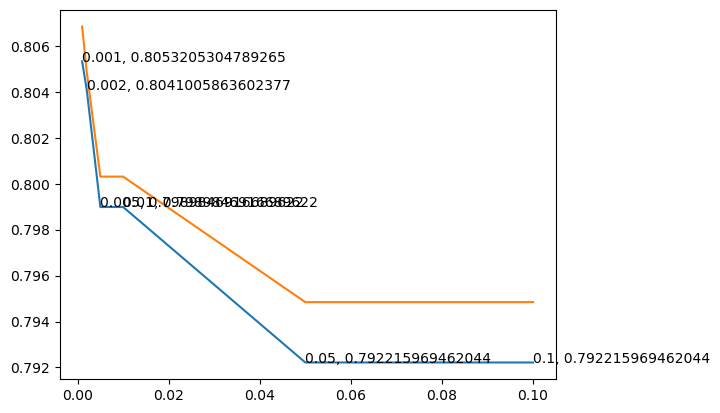

[0.8053205304789265, 0.8041005863602377, 0.7989846916689622, 0.7989846916689622, 0.792215969462044, 0.792215969462044]


In [25]:
# calls my kNN_tester function to assess the accuracy of decision trees with different ccp_alphas
lst = kNN_tester(inputs_train, target_train, inputs_test, target_test, [.001, .002, .005, .01, .05, .1])
print(lst)

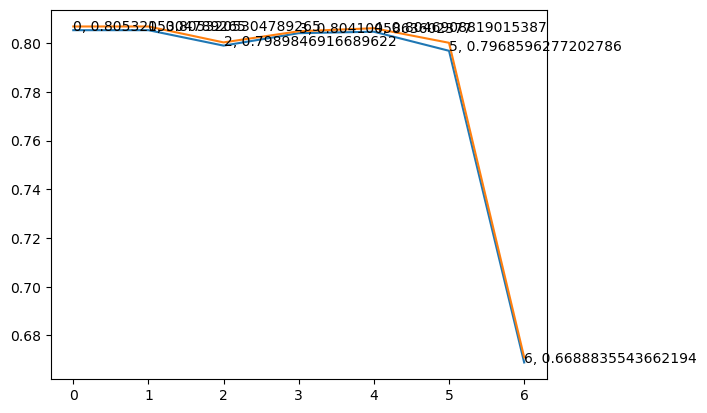

[0.8053205304789265, 0.8053205304789265, 0.7989846916689622, 0.8041005863602377, 0.8046908819015387, 0.7968596277202786, 0.6688835543662194]


In [26]:
# test if excluding any features would change the accuracy og my function
lst = exclude_feature_tester(inputs_train, target_train, inputs_test, target_test, list(range(0,7)), 0.001)
print(lst)

In [27]:
# makes my decision tree
dt1  = DecisionTreeClassifier(ccp_alpha = .001)
dt1.fit(inputs_train, target_train)

DecisionTreeClassifier(ccp_alpha=0.001)

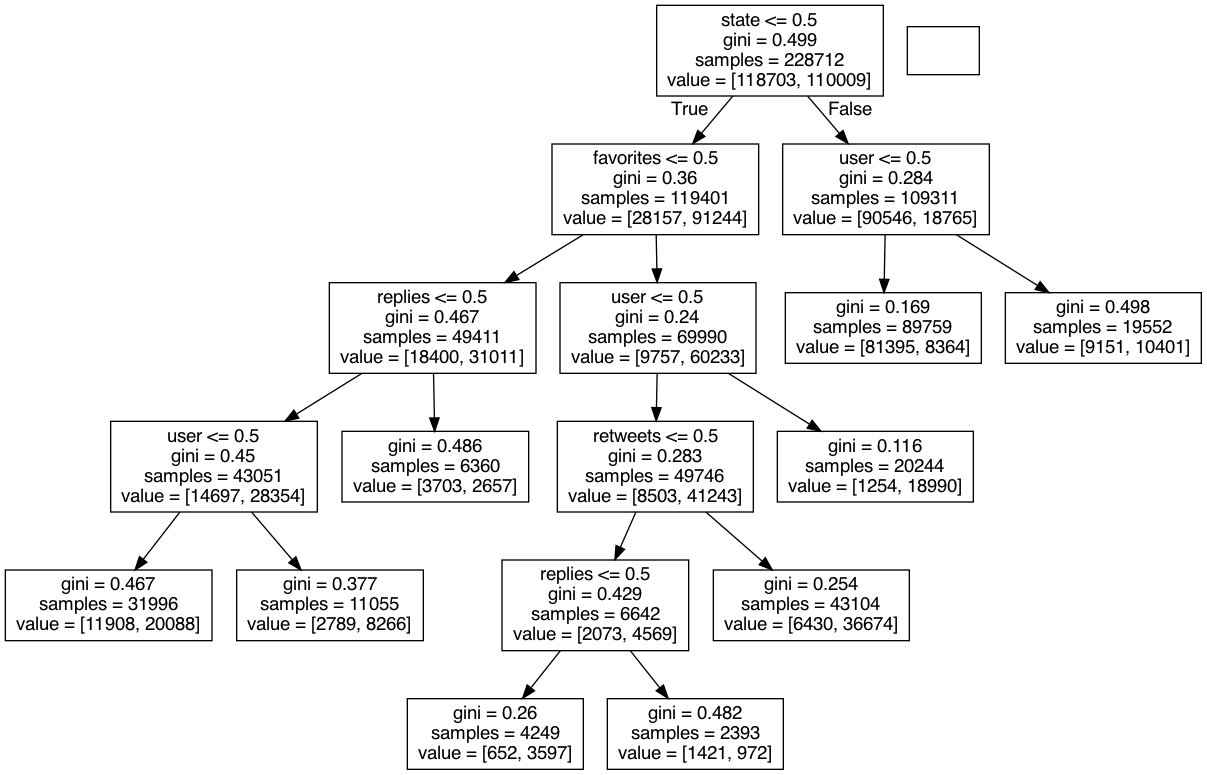

In [28]:
# Visualization of the decision tree I made
dot_data = StringIO()

export_graphviz(dt1, out_file=dot_data, feature_names=var_names)
(dt_vis, ) = graph_from_dot_data(dot_data.getvalue())

Image(dt_vis.create_png())


In [29]:
# predict for the test inputs using my decsion tree ???
predicted = dt1.predict(inputs_test)

In [30]:
#https://stackoverflow.com/questions/51016230/how-to-change-values-in-a-column-into-binary

bnry = {True: 1,False: 0}
tree_test_df.party = [bnry[item] for item in tree_test_df.party]
tree_test_df.party

/var/folders/db/xmky6pss74xfs37s84gt2sp80000gn/T/ipykernel_48213/4051474881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_test_df.party = [bnry[item] for item in tree_test_df.party]


266695    0
130713    1
129819    1
112860    1
143264    0
         ..
158340    0
193623    1
125085    1
195587    1
219929    1
Name: party, Length: 25411, dtype: int64

In [31]:
np.mean(predicted == tree_test_df.party)

0.8053205304789265

## Model 2: SVM
***
### Pre-processing my SVM Training Data 
***
To make my tweet data work well for an SVM model, I have to make it numerical. To do this, I create a TfidfVectorizer, which turns my text data into a dictionary of vectorized words. TfidfVectorizer assigns each word in my tweets a numerical ID, and then counts how many times it appears. TfidfVectorizer also has parameters that I can set to filter unhelpful or distracting words out of my sample. I set it to do the following:
* Remove unicode characters, which tend to not be encoded correctly and confuse text analyzers (for example, emojis)
* Remove english stopwords, which are words that appear frequently but lack non grammatical meaning (for example, "the)
* Not count words that show up in less than .5% of my tweets
  * This was computed using my `min_df_tester` function, which created svm models with different min_df's to see which filter parameters changed the score

TfidfVectorizer also reduces weight of words that occur in too many documents, since they may be less helpful in comparison tasks like this one if they are just everywhere. I then build an analyzer so I can check that my filtering was successful enough, for example making sure there are no completely random characters. 


In [46]:
# initializes TfidfVectorizer 
vect = TfidfVectorizer(strip_accents = "unicode", stop_words = {'english'}, min_df=0.005)  

vect

TfidfVectorizer(min_df=0.005, stop_words={'english'}, strip_accents='unicode')

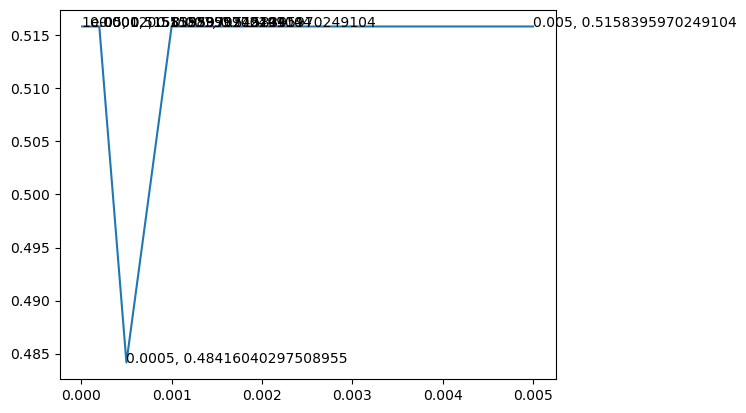

[0.5158395970249104,
 0.5158395970249104,
 0.5158395970249104,
 0.48416040297508955,
 0.5158395970249104,
 0.5158395970249104]

In [44]:
# find well performing min_df

min_df_tester(svm_train_df, svm_test_df, 'text', 'party', [.00001, .0001, .0002, .0005, .001, .005], 'squared_error')

In [47]:
# fits (performs value calculation) and transforms (applies calculation to every data point) 
train_vect = vect.fit_transform(svm_train_df.text)

# checks the shape
print(train_vect.shape)

(228712, 434)


Counts unique words and their occurrences across the texts (there were 228712 rows (texts), 9742 unique words)
* Before I added the filter factors to my count_vec, there were 295789 unique words, so stuff is being filtered

In [48]:
# builds analyzer, which lets me handle preprocessing and tokenization for words that are > 2 char
analyzer = vect.build_analyzer()

# prints the words in the analyzer, so I can check that none of it looks crazy
vect.get_feature_names_out()

array(['000', '10', '11', '1st', '30', 'about', 'aca', 'access', 'across',
       'act', 'action', 'address', 'admin', 'administration',
       'affordable', 'after', 'ag', 'again', 'against', 'ago', 'agree',
       'all', 'also', 'always', 'am', 'amendment', 'america', 'american',
       'americans', 'amp', 'an', 'and', 'another', 'any', 'ao', 'ao_',
       'aon', 'are', 'around', 'as', 'at', 'award', 'back', 'be',
       'because', 'been', 'before', 'being', 'best', 'better', 'big',
       'bill', 'bipartisan', 'birthday', 'budget', 'business',
       'businesses', 'but', 'by', 'call', 'can', 'care', 'celebrate',
       'center', 'change', 'check', 'children', 'city', 'climate', 'co',
       'colleagues', 'college', 'come', 'coming', 'committee',
       'communities', 'community', 'congrats', 'congratulations',
       'congress', 'continue', 'corybooker', 'costs', 'could', 'country',
       'county', 'court', 'coverage', 'create', 'crisis', 'critical',
       'ct', 'cut', 'cuts', 'da

### Pre-processing my SVM Testing Data 
***
In order to make my test data compatible with my model, I have to pre-process it the same way I did my svm train data. I transform my test data using the same TfidfVectorizer I created for the train data, to ensure it is being filtered by the same parameters. I do not fit the test data though, because the model is not supposed to be trained on it. 


In [49]:
# adapt test data
new_counts = vect.transform(svm_test_df.text)
print(new_counts.shape) 


(25411, 434)


### Training my SVM classifier
***
Now that I have made my data numerical, I need to classify it. To do this

cf, pr, tl = prj2.make_my_svm(svm_train_df, svm_test_df, 'text', 'party')

In [50]:
def min_df_tester(trn_df, tst_df, inp, target, mindf_list, loss):
     
    test_list = []
    
    for mindf in mindf_list:
        
        cf, pred, tl = make_my_svm(trn_df, tst_df, inp, target, mindf, loss)
        
        test_list.append(accuracy_score(tst_df[target], pred))
        
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(mindf_list, test_list)
    
    for i in range (len(mindf_list)):
        plt.text(mindf_list[i], test_list[i], f'{mindf_list[i]}, {test_list[i]}')
    plt.show()
    
    return(test_list)

In [58]:
def loss_tester(trn_df, tst_df, inp, target, mindf, loss_list):
     
    test_list = []
    
    for loss in loss_list:
        
        cf, pred, tl = make_my_svm(trn_df, tst_df, inp, target, mindf, loss)
        
        test_list.append(accuracy_score(tst_df[target], pred))
        
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(loss_list, test_list)
    
    for i in range (len(loss_list)):
        plt.text(i, test_list[i], f'{i}, {test_list[i]}')
    plt.show()
    
    return(test_list)
    

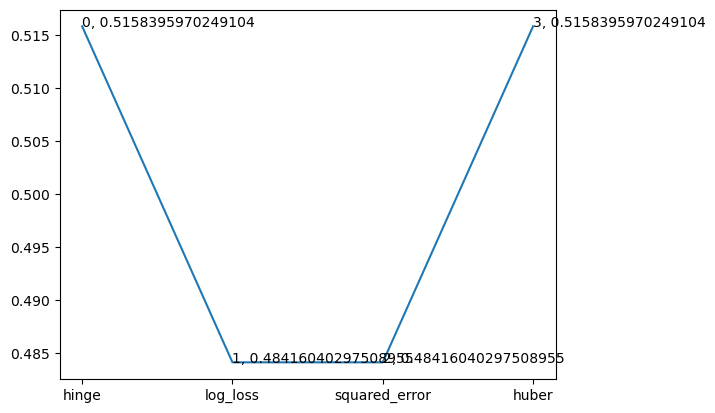

[0.5158395970249104,
 0.48416040297508955,
 0.48416040297508955,
 0.5158395970249104]

In [61]:
# find the best performing loss system for clustering algorithm

loss_tester(svm_train_df, svm_test_df, 'text', 'party', .005, ['hinge', 'log_loss', 'squared_error', 'huber'])


In [66]:
from sklearn.linear_model import SGDClassifier # SVM classifier

classf = SGDClassifier(loss='hinge').fit(train_vect, svm_train_df.party) 

In [67]:
predicted = classf.predict(new_counts)

In [68]:
print(predicted)

['R' 'D' 'D' ... 'D' 'R' 'D']


In [69]:
np.mean(predicted == svm_test_df.party)

0.6767541615835662

## Cross Validation
***
To compare the efficacy of my 2 models, I am using cross validation with the test data from the start of the project, to see which model will perform better when faced with new data. 

In [74]:
# calculate the cross validated scores, based on accuracy
scores = cross_val_score(classf, new_counts, svm_test_df.party, cv = 10, scoring = 'accuracy')

# print my scores
print("%0.2f accuracy with a standard deviation of %0.2f \n" % (scores.mean(), scores.std()))

print(scores)

0.67 accuracy with a standard deviation of 0.00 

[0.66325728 0.66627312 0.67099567 0.66902794 0.67611177 0.66666667
 0.67217631 0.67768595 0.67217631 0.66233766]


In [76]:
# calculate the cross validated scores, based on accuracy
scores = cross_val_score(dt1, tree_test_df.loc[:,tree_test_df.columns!='party'], tree_test_df["party"], cv = 10, scoring = 'accuracy')

# print my scores
print("%0.2f accuracy with a standard deviation of %0.2f \n" % (scores.mean(), scores.std()))

print(scores) 

0.81 accuracy with a standard deviation of 0.01 

[0.78796223 0.81188508 0.80913026 0.80637544 0.8103109  0.80519481
 0.80519481 0.80834317 0.7965368  0.81463991]


## Final Thoughts
***
The tree has a better accuracy in predictin than the SVM based on the cross validation performed here. The lowest performing tree had a better accuracy than the best SVM, which means that the tree model is way more successful for this task. 